# Model Testing Notebook

## Objectives

* 


## Inputs

* 

## Outputs

* 
  


---

In [1]:
import matplotlib.pyplot as plt
from IPython.display import Image
import pandas as pd
from keras.models import load_model
import pickle
import gc
from keras.models import load_model
from tqdm.autonotebook import tqdm
from keras.preprocessing.image import load_img
import numpy as np
from keras.layers import Input, Lambda, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from keras.applications import InceptionV3, Xception, NASNetLarge, InceptionResNetV2
from keras.applications.inception_v3 import preprocess_input as inception_preprocessor
from keras.applications.xception import preprocess_input as xception_preprocessor
from keras.applications.nasnet import preprocess_input as nasnet_preprocessor
from keras.applications.inception_resnet_v2 import preprocess_input as inc_resnet_preprocessor


2024-05-08 10:05:27.138648: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-08 10:05:27.138826: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-08 10:05:27.140684: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-08 10:05:27.162059: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 10:05:27.530243: W tensorflow/compiler/tf2tensorrt/utils/py_uti

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/home/jaaz/Desktop/project-5/TailTeller/jupyter_notebooks'

We want to make the parent of the current directory the new current directory.
* os.path.dirname() gets the parent directory
* os.chdir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("New current directory:", os.getcwd())

New current directory: /home/jaaz/Desktop/project-5/TailTeller


---

### Let's load the get_features function again in order to run the dog images in the train/ folder through the models we already know. This folder was untouched until now and will be used from now on to see how our model performs.

In [7]:
img_size = (299,299,3)

def get_features(model_name, model_preprocessor, input_size, data):

    input_layer = Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    
    #Extract feature
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

# Let's read the images from the test directory

Creating a function to load the images in the train/ folder, pre-process them into a numpy array and also return the corresponding ids (breed labels) before extracting the features:

In [8]:
def load_test_images(data_dir, img_size=(299, 299, 3)):
    """
    This function loads and processes images from the test/ directory into a numpy array
    Parameters:
        test_dir: str, path to the directory containing the test images
        img_size: tuple, size to which the images should be resized (width, height, channels)
    Returns:
        A numpy array containing the processed images
        A list of filenames (ids) of the images
    """
    # Making the full file paths for each image in the test directory
    test_filenames = [os.path.join(data_dir, fname) for fname in os.listdir(data_dir)]

    # Determine the number of images
    data_size = len(test_filenames)

    #Preallocate a numpy array to hold all images
    images = np.zeros((data_size, img_size[0], img_size[1], img_size[2]), dtype=np.uint8)
    
    #Load each image, resize it and store it in the preallocated array
    for ix, img_path in enumerate(tqdm(test_filenames, desc="Processing images")):
        img = load_img(img_path, target_size=img_size)
        images[ix] = img
        # Free RAM
        del img
    
    # Display the final data size
    print(f"Final data size {images.shape}")

    # Extract ids from filenames
    ids = [os.path.basename(fname).split('.')[0] for fname in test_filenames]

    return images, ids

Assigning the numpy array transformed 5111 training images plus the ids into the test_data variable:

In [10]:
test_data, ids = load_test_images('images/test/')

# Save the ids to a pickle file
with open('ids.pkl', 'wb') as f:
    pickle.dump(ids, f)

Processing images: 100%|██████████| 5111/5111 [00:03<00:00, 1589.85it/s]

Final data size (5111, 299, 299, 3)


This function will extract the features taking the same models we've used before and return a variable concatenating all the 4 model features:

In [8]:
def extract_features(data, img_size=(299, 299, 3)):
    """
    Extracts features from test data using multiple pre-trained models 
    and concatenate them
    Parameters:
        data: numpy array, the input data we need to extract features from
        img_size: tuple, size to which the images
        should be resized (width, height, channels)
    Returns:
        a numpy array containing concatenated features from multiple models
    """
    # Extract features using InceptionV3
    inception_features = get_features(InceptionV3, inception_preprocessor, img_size, data)

    # Extract features using Xception
    xception_features = get_features(Xception, xception_preprocessor, img_size, data)

    # Extract features using NASNetLarge
    nasnet_features = get_features(NASNetLarge, nasnet_preprocessor, img_size, data)

    # Extract features using InceptionResNetV2
    inc_resnet_features = get_features(InceptionResNetV2, inc_resnet_preprocessor, img_size, data)

    # Concatenate all extracted features along the last axis
    final_features = np.concatenate(
        [inception_features, xception_features, nasnet_features, inc_resnet_features],
        axis=-1
    )

    # Free RAM
    del inception_features, xception_features, nasnet_features, inc_resnet_features
    gc.collect()

    return final_features

Assigning the extracted features from test_data (the dog pictures inside train/) into the test_features variable:

In [9]:
test_features = extract_features(test_data)

160/160 ━━━━━━━━━━━━━━━━━━━━ 79s 491ms/step
Feature maps shape:  (5111, 2048)
160/160 ━━━━━━━━━━━━━━━━━━━━ 154s 963ms/step
Feature maps shape:  (5111, 2048)
160/160 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step
Feature maps shape:  (5111, 4032)
160/160 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step
Feature maps shape:  (5111, 1536)


Let's load our tailteller Keras model and use the predict function to generate predictions for the input samples in the dataset.

In [ ]:
model = load_model('tailteller_model.keras')
# Predict test labels given test data features.
test_predict = model.predict(test_features)

In [11]:
# Save the predictions to a pickle file
with open('test_predict.pkl', 'wb') as f:
    pickle.dump(test_predict, f)

# softmax usage
We are now taking the first [0] image test into our prediction and doing the following:

1. Print prediction results for the set of input features.
2. Print the highest probability in the prediction array.
3. Since softmax was used in the output layer of the model the sum of all probabilities should be 1 or extremely close.
4. Print the index (dog breed label index) with the maximum probability.
5. Load the breed file and predict the label with the number printed on point 4.

In [12]:
# First prediction
print(f"{test_predict[0]}")
# Display the predicted label
print(f"Max value (probability of prediction): {np.max(test_predict[0])}")
# Display the sum of all values
print(f"Sum: {np.sum(test_predict[0])}")
# Display the index of the max value
print(f"Max index: {np.argmax(test_predict[0])}")

with open('breeds.pkl', 'rb') as f:
    breeds = pickle.load(f)
# Display the breed of the predicted label
print(f"Predicted label: {breeds[np.argmax(test_predict[0])]}")




[7.3257212e-07 5.3957319e-07 2.2843626e-06 1.7315773e-07 9.8438489e-01
 6.1256113e-05 4.2795946e-06 2.0419360e-05 3.6058018e-06 1.5745040e-06
 5.4307261e-08 1.8964552e-07 8.0313157e-08 1.2103949e-06 4.5403053e-07
 3.4823036e-06 2.1855878e-05 1.6804074e-06 3.0117994e-07 7.6820441e-05
 8.9433206e-07 1.8495266e-05 3.8524433e-07 5.5454819e-07 6.6077877e-07
 1.5465166e-05 4.0413038e-06 7.0832252e-06 2.5227182e-06 1.7697072e-06
 2.4996231e-07 3.9671236e-06 1.1506752e-07 7.4150198e-06 2.7816571e-07
 1.4493536e-06 4.4531180e-06 5.0213803e-06 8.2465940e-06 2.0534426e-06
 1.0580070e-06 2.0215828e-07 6.6120106e-07 1.2273124e-05 2.6187783e-07
 7.3325118e-06 3.8815256e-07 1.0732383e-06 4.8095467e-07 7.6987026e-06
 1.5305210e-07 9.0542417e-05 7.1702993e-07 3.4345167e-06 1.2604113e-07
 3.8736180e-06 1.0006381e-06 6.6061995e-07 4.1250686e-08 4.0364425e-06
 1.0677536e-05 7.6468336e-07 8.9838312e-07 1.5348593e-05 1.6135588e-06
 4.0269920e-06 1.6446107e-07 1.5452347e-06 3.3533599e-06 9.5338714e-07
 6.120

### Now let's see the image we have just predicted:

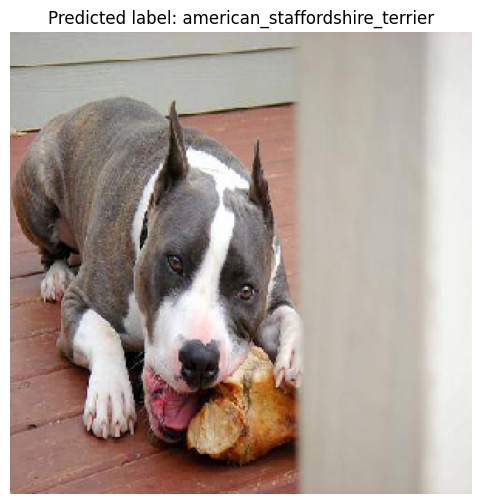

In [13]:
img_to_show = test_data[0].astype('uint8')

plt.figure(figsize=(6,6))
plt.imshow(img_to_show)
plt.title(f"Predicted label: {breeds[np.argmax(test_predict[0])]}")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()